In [6]:
# Imports etc.
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.utils.train import read_config
from src.utils.datasets import get_dataloaders, denormalize
from src.agent.unit import UNIT

In [7]:
root = '../../../results/UNIT_CATARACTS_Cataract101_192pix/2022_10_13-08_46_20/'
assert os.path.isdir(root)
conf, _ = read_config(root + "config.yml")
conf.device = 'cuda'
conf.data.seq_frames_test = 10
conf.testing.batch_size = 1

In [8]:
# Load data
_, test_dl = get_dataloaders(conf, shuffle_test=True)

3295
705
Domain A --- Training: 1873 --- Testing: 1837
Domain B --- Training: 3295 --- Testing: 705


# Input sequence and frame-wise absolute difference maps

In [9]:
sample = next(iter(test_dl))
seq_A = sample['A'].to(conf.device)
seq_B = sample['B'].to(conf.device)
N, T, C, H, W = seq_A.shape

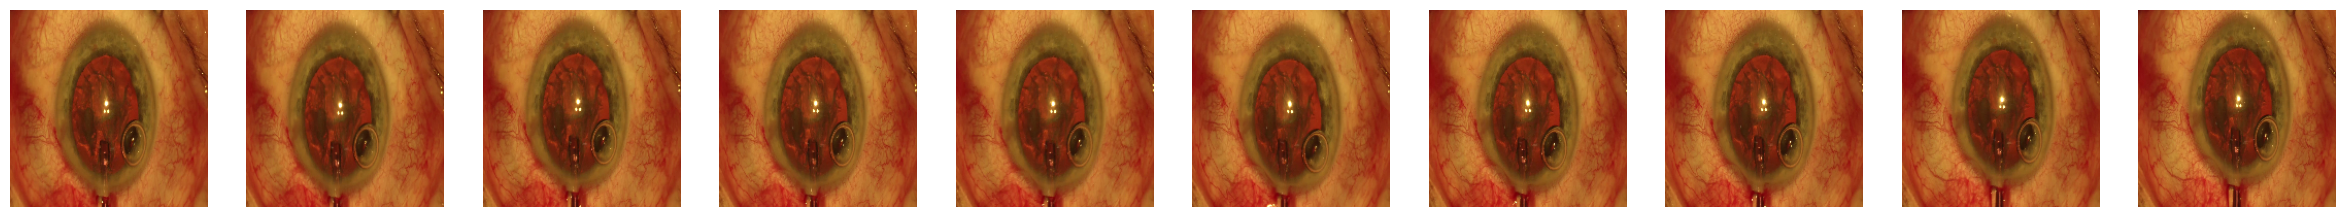

In [10]:
fig, ax = plt.subplots(1, T, figsize=(T*3, 3))
for t in range(T):
    ax[t].imshow(denormalize(seq_A[0, t]).permute(1, 2, 0).cpu())
    ax[t].axis('off')
plt.show()

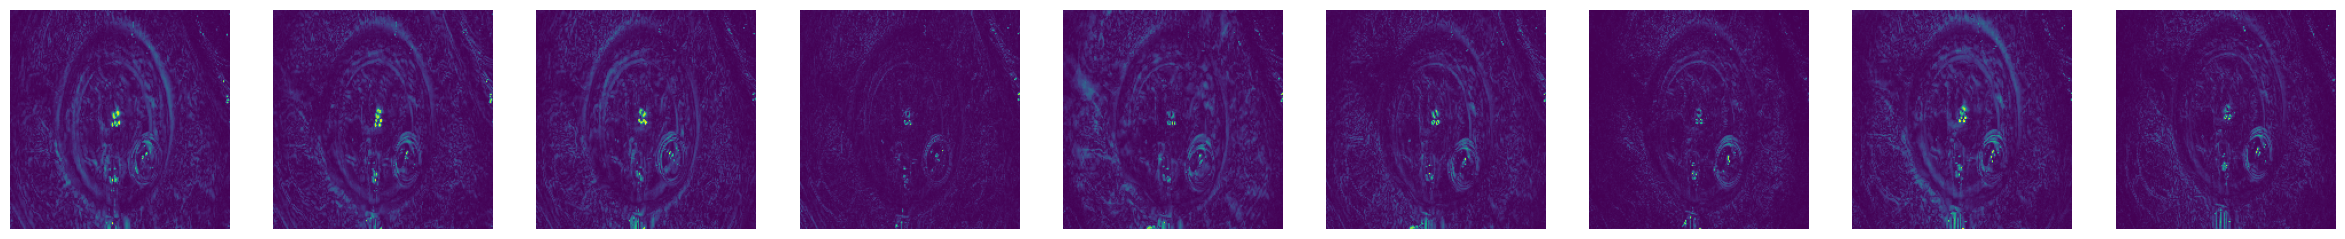

In [11]:
# Frame-wise diff
fig, ax = plt.subplots(1, T-1, figsize=(T*3, 3))
for t in range(T-1):
    ax[t].imshow(torch.abs(seq_A[0, t] - seq_A[0, t+1]).clip(0, 1).mean(dim=0).cpu())
    ax[t].axis('off')
plt.show()

# Translated sequence and absolute difference maps

In [14]:
agent = UNIT(conf)
agent.gen_A.load_state_dict(torch.load(root + "checkpoints/gen_A_epoch199.pth", map_location='cpu'))
agent.gen_B.load_state_dict(torch.load(root + "checkpoints/gen_B_epoch199.pth", map_location='cpu'))

<All keys matched successfully>

In [15]:
with torch.no_grad():
    h_a, n_a = agent.gen_A.encode(seq_A.view(N*T, C, H, W))
    fake_seq_AB = agent.gen_B.decode(h_a + n_a).view((N, T, C, H, W))
fake_seq_AB.shape

torch.Size([1, 10, 3, 192, 192])

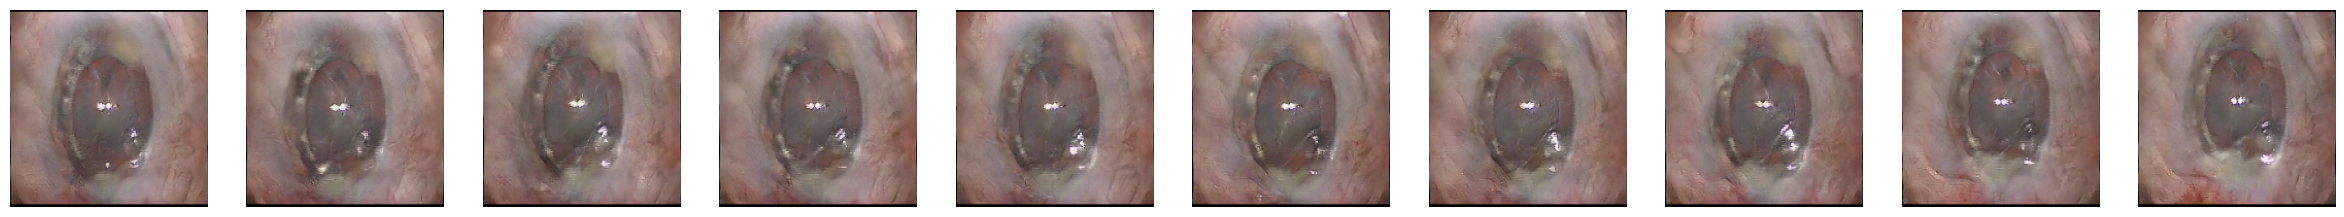

In [16]:
fig, ax = plt.subplots(1, T, figsize=(T*3, 3))
for t in range(T):
    ax[t].imshow(denormalize(fake_seq_AB[0, t]).permute(1, 2, 0).cpu())
    ax[t].axis('off')
plt.show()

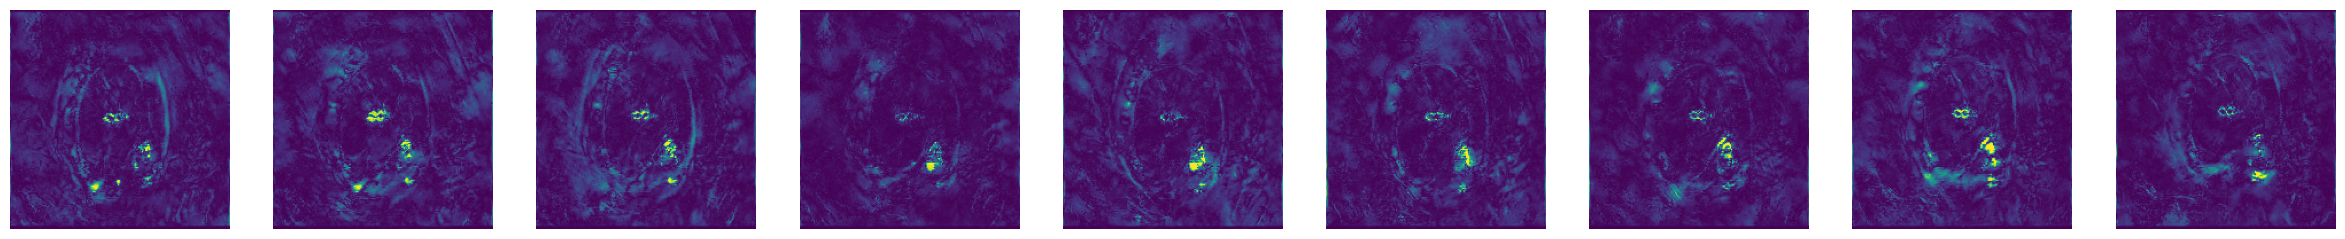

In [17]:
# Frame-wise diff
fig, ax = plt.subplots(1, T-1, figsize=(T*3, 3))
for t in range(T-1):
    ax[t].imshow(torch.abs(fake_seq_AB[0, t] - fake_seq_AB[0, t+1]).clip(0, 1).mean(dim=0).cpu())
    ax[t].axis('off')
plt.show()

In [ ]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
d = rmse
dists = []
for t in range(1, T):
    dist = d(torch.abs(seq_A[0, t] - seq_A[0, t-1]).permute(1, 2, 0).cpu().numpy(),
             torch.abs(fake_seq_AB[0, t] - fake_seq_AB[0, t-1]).permute(1, 2, 0).cpu().numpy())
    dists.append(dist)
print(dists)

In [ ]:
distm = torch.empty(size=(T, T))
for t in range(T):
    for _t in range(T):
        dist = d(torch.abs(seq_A[0, t] - seq_A[0, _t]).permute(1, 2, 0).cpu().numpy(),
                 torch.abs(fake_seq_AB[0, t] - fake_seq_AB[0, _t]).permute(1, 2, 0).cpu().numpy())
        distm[t, _t] = dist
plt.imshow(distm, cmap='plasma', vmin=0.0, vmax=0.5)

In [ ]:
distm = torch.empty(size=(T, T))
for t in range(T):
    for _t in range(T):
        dist = d(torch.abs(seq_A[0, t] - seq_A[0, _t]).permute(1, 2, 0).cpu().numpy(),
                 torch.abs(seq_B[0, t] - seq_B[0, _t]).permute(1, 2, 0).cpu().numpy())
        distm[t, _t] = dist
plt.imshow(distm, cmap='plasma', vmin=0.0, vmax=0.5)

In [ ]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
d = rmse
fig, ax = plt.subplots(1, T, figsize=(T*5, 3))
distm = torch.empty(size=(T, T))
for t in range(T):
    dists = [d(torch.abs(seq_A[0, t] - seq_A[0, _t]).permute(1, 2, 0).cpu().numpy(),
               torch.abs(fake_seq_AB[0, t] - fake_seq_AB[0, _t]).permute(1, 2, 0).cpu().numpy()) for _t in range(T)]
    distm[t] = torch.tensor(dists)
    ax[t].bar(np.arange(0, T), dists)
    ax[t].set_ylim(0.0, 0.5)
plt.show()

In [ ]:
plt.imshow(distm, cmap='plasma', vmin=0.0, vmax=1.0)